<img src="./pictures/logo_sizinglab.png" style="float:right; max-width: 60px; display: inline" alt="SizingLab" /></a>

# Sizing of a multi-rotor drone with a FMU of transient climb

*Written by Marc Budinger, Aitor Ochotorena (INSA Toulouse) and Scott Delbecq (ISAE-SUPAERO), Toulouse, France.*  
*FMU addition by Marc Budinger (NSA Toulouse)*

The objective of this notebook is to select the best compromise of components (propeller, motor, ESC, battery) of a multi-rotor drone for given specifiations.

**Scipy** and **math** packages will be used for this notebook in order to illustrate the optimization algorithms of python.

In [1]:
import scipy
import scipy.optimize
from math import pi
from math import sqrt
from math import sin
import math
import numpy as np
import timeit
import pandas as pd
from IPython.display import display, HTML

import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

pd.options.display.float_format = '{:,.2f}'.format

## Sizing code

The set of equations of a sizing code can generate typical issues such : 
- Underconstrained set of equations: the lacking equations can come from additional scenarios, estimation models or additional sizing variable.   
- overconstrained equations often due to the selection of a component on multiple critera: the adding of over-sizing coefficients and constraints in the optimization problem can generally fix this issue   
- algebraic loops often due to selection criteria requiring informations generally available after the selection 

Concerning overconstraints components, we have here:
- Brushless motors with multiple torque and voltage constraints (hover and transient vertical displacement) 

Multiple algebraic loops appears in the sizing problem:
- The thrust depends of the total mass which depend of components required for generating this thrust

The final optimization problem depends thus of these parameters:
- $\beta_{pro}=pitch/diameter$ ratio to define the propeller
- $k_{os}$ over sizing coefficient on the load mass to estimate the final total mass
- $k_{mot}$ over sizing coeffcient on the motor torque to estimate the max torque with the hover flight conditions
- $k_{speed,mot}$ over sizing coeffcient on the motor speed to take into account voltage limits during hover or take-off flight
- $k_{ND}$ slow down propeller coef : ND = kNDmax / k_ND
- $k_{D}$ aspect ratio e_arm/D_out_arm (thickness/diameter) for the beam of the frame
- $k_{mb}$ ratio battery mass / payload mass
- $k_{vb}$ over sizing coefficient for the battery voltage
- $\alpha$ a duty cycle for the transient mission profile
- $k_t$ a normalized coefficient for time definition

## Objectives and specifications

Main specifications :
- a load (video, control card) of mass $M_{load}$.  
- an autonomy $t_{hf}$ for the hover flight.
- an acceleration to take off $a_{to}$.


In [2]:
# Specifications

# Load
M_pay = 25. # [kg] load mass
S_pay = .4*.4 # Payload surface

# Acceleration during take off
# a_to = 0.25 * 9.81 # [m/s²] acceleration

# Load displacements
N_dis = 150 # [-] Displacements number
H_dis = 10 # [m] Elevation

# Autonomy
t_hov_spec = 5/60*N_dis # [min] time of full load hover flight



## Constants, Architecture definition and design assumptions

In [3]:
# Constants
g=9.81 # [m/s²] gravity acceleration

# Architecture of the multi-rotor drone (4,6, 8 arms, ...)
N_arm = 4 # [-] number of arm
N_pro_arm = 1 # [-] number of propeller per arm (1 or 2)
N_pro = N_pro_arm * N_arm # [-] Propellers number

## Reference parameters

- ### Battery & ESC

In [4]:
# Reference parameters for scaling laws
# Ref : MK-quadro
M_bat_ref = .329 # [kg] mass
E_bat_ref = 220.*3600.*.329 # [J]

# Ref : Turnigy K_Force 70HV 
P_esc_ref = 3108. # [W] Power
M_esc_ref = .115 # [kg] Mass

- ### Motor

In [5]:
# Motor reference
# Ref : AXI 5325/16 GOLD LINE
T_nom_mot_ref = 2.32  # [N.m] rated torque
T_max_mot_ref = 85./70.*T_nom_mot_ref # [N.m] max torque
R_mot_ref = 0.03  # [Ohm] resistance
M_mot_ref = 0.575 # [kg] mass
K_mot_ref = 0.03 # [N.m/A] torque coefficient
T_mot_fr_ref = 0.03 # [N.m] friction torque (zero load, nominal speed)


- ### Frame

In [6]:
# Reference parameters for scaling laws
sigma_max = 280e6/4. # [Pa] Composite max stress (2 reduction for dynamic, 2 reduction for stress concentration)
rho_s = 1700. # [kg/m3] Volumic mass of aluminum

- ### Propeller

In [7]:
# Specifications
rho_air=1.18# [kg/m^3] Air density
ND_max=105000./60.*.0254 #[Hz.m] Max speed limit (N.D max) for APC MR propellers


# Reference parameters for scaling laws
D_pro_ref=11.*.0254# [m] Reference propeller diameter
M_pro_ref=0.53*0.0283# [kg] Reference propeller mass

- ### FMU

In [8]:
# Check directory

import os
import os.path as pth
# print(os.getcwd())  # Prints the current working directory
# os.chdir('C:\\Users\\mbudinge\\Documents\\Bureautique\\Recherche\\Articles\\1_Conferences\\2021_Scitech\\optimTrajectoire')

In [9]:
import numpy as np

import scipy
import scipy.optimize
from math import pi
import timeit

from pyfmi import load_fmu
ressources_folder = "../ressources"
model_file_name = "DroneFMU_TestProfilOptim_J.fmu"

file_path = pth.join(ressources_folder, model_file_name)

#Load the FMU
model = load_fmu(file_path) # Model

# /!\ a generer un modele FMU avec une tolerance pas trop grossiere
print("Tolerance: ",model.get_default_experiment_tolerance())
print("Generation tool: ",model.get_generation_tool())


Tolerance:  0.0001
Generation tool:  Optimica Compiler Toolkit


In [20]:
import sys
import tempfile


# -----------------------
# sizing code
# -----------------------
# inputs: 
# - param: optimisation variables vector (reduction ratio, oversizing coefficient)
# - arg: selection of output  
# output: 
# - objective if arg='Obj', problem characteristics if arg='Prt', constraints other else
def sizing_code(param, arg):
# Design variables
# ---
    beta_pro = param[0] # pitch/diameter ratio of the propeller
    k_os = param[1] # over sizing coefficient on the load mass 
    k_ND = param[2] # slow down propeller coef : ND = kNDmax / k_ND
    k_mot = param[3] # over sizing coefficient on the motor torque
    k_speed_mot = param[4] # over sizing coefficient on the motor speed
    k_mb = param[5] # ratio battery / payload mass 
    k_vb = param[6] # over sizing coefficient for the battery voltage
    k_D = param[7] # aspect ratio e_arm/D_out_arm (thickness/diameter) for the beam of the frame
    a_to = param[8]*9.81 # equvalent Take-off acceleration in orer to have equivalent max motor torque
    alpha = param[9] # time ratio for propeller acceleration
    time = np.sqrt(6*H_dis/g/(1-alpha))*param[10] # Elevation travel time k_t ratio
    
# Hover& Take-Off thrust 
# ---
    M_total = k_os * M_pay # [kg] Estimation of the total mass (or equivalent weight of dynamic scenario)
    F_pro_hov = M_total * (9.81) / N_pro # [N] Thrust per propeller for hover
    F_pro_to = M_total * (9.81 + a_to) / N_pro # [N] Thrust per propeller for take-off

#PROPELLER
# --- 

    # Static thrust and power coefficien

    C_t = 4.27e-02 + 1.44e-01 * beta_pro  # Thrust coef with T=C_T.rho.n^2.D^4 - 0.8 for de-rating of APC catalog
    C_p = -1.48e-03 + 9.72e-02 * beta_pro  # Power coef with P=C_p.rho.n^3.D^5

    # Propeller selection with take-off scenario
    D_pro = (F_pro_to / (C_t*rho_air*(ND_max/k_ND)**2.))**0.5 # [m] Propeller diameter
    n_pro_to = ND_max / k_ND / D_pro # [Hz] Propeller speed 
    Omega_pro_to = n_pro_to * 2*pi # [rad/s] Propeller speed

    M_pro = M_pro_ref * (D_pro/D_pro_ref)**2. # [kg] Propeller mass
    J_pro = M_pro * (D_pro/2)**2 / 3 # [kg.m²] Propeller inertia
    
    P_pro_to = C_p * rho_air * n_pro_to**3. * D_pro**5. # [W] Power per propeller
    T_pro_to = P_pro_to / Omega_pro_to # [N.m] Propeller torque

    # Propeller torque & speed for hover
    n_pro_hov = sqrt(F_pro_hov/(C_t * rho_air *D_pro**4.)) # [Hz] hover speed
    Omega_pro_hov = n_pro_hov * 2.*pi # [rad/s] Propeller speed

    P_pro_hov = C_p * rho_air * n_pro_hov**3. * D_pro**5. # [W] Power per propeller
    T_pro_hov = P_pro_hov / Omega_pro_hov # [N.m] Propeller torque       
    U_bat_est = k_vb*1.84*P_pro_to**(0.36) # [V] battery voltage estimation

# MOTOR
# --- 
    T_nom_mot = k_mot * T_pro_hov   # [N.m] Motor nominal torque per propeller

    M_mot = M_mot_ref * (T_nom_mot/T_nom_mot_ref)**(3./3.5) # [kg] Motor mass

    # Selection with take-off speed
    K_mot = U_bat_est / (k_speed_mot*Omega_pro_to) # [N.m/A] or [V/(rad/s)] Kt motor

    R_mot = R_mot_ref * (T_nom_mot/T_nom_mot_ref)**(-5./3.5)*(K_mot/K_mot_ref)**2.  # [Ohm] motor resistance
    T_mot_fr = T_mot_fr_ref * (T_nom_mot/T_nom_mot_ref)**(3./3.5) # [N.m] Friction torque
    T_max_mot = T_max_mot_ref * (T_nom_mot/T_nom_mot_ref)

    # Hover current and voltage
    I_mot_hov = (T_pro_hov+T_mot_fr) / K_mot # [I] Current of the motor per propeller
    U_mot_hov = R_mot*I_mot_hov + Omega_pro_hov*K_mot # [V] Voltage of the motor per propeller
    P_el_mot_hov = U_mot_hov*I_mot_hov # [W] Hover : electrical power

    # Takeoff current and voltage
    I_mot_to = (T_pro_to+T_mot_fr) / K_mot # [I] Current of the motor per propeller
    U_mot_to = R_mot*I_mot_to + Omega_pro_to*K_mot # [V] Voltage of the motor per propeller
    P_el_mot_to = U_mot_to*I_mot_to # [W] Takeoff : electrical power


#FMU: elevation simulation
# ---
    # Launch FMU simulation
    
    #/!\ changer nb de moteur a terme
    
    
    
    model.reset()
    model.set('droneMassPropeller_TorqueInput_J.beta', beta_pro)
    model.set('profilTable2_1.T', time)
    model.set('droneMassPropeller_TorqueInput_J.d', D_pro)
    model.set('droneMassPropeller_TorqueInput_J.J_pro', J_pro)
    model.set('droneMassPropeller_TorqueInput_J.S', S_pay)
    model.set('droneMassPropeller_TorqueInput_J.M', M_total)
    model.set('droneMassPropeller_TorqueInput_J.K_mot', K_mot)
    model.set('droneMassPropeller_TorqueInput_J.R_mot', R_mot)
    model.set('droneMassPropeller_TorqueInput_J.Np', N_pro)
    model.set('profilTable2_1.H', H_dis)
    model.set('profilTable2_1.Alpha', alpha)
        
    # Simulate
       
    #sys.stdout.close()   # empeche print consle
    sys.stdout = open(os.devnull, "w")
    
    res = model.simulate(final_time=float(time))     
    sys.stdout = sys.__stdout__ # autorise print

    
    # Get results
    NRJ = res['NRJ.y'] #Return the result for the variable/parameter/constant y
    n = res['droneMassPropeller_TorqueInput_J.n']
    t = res['time']
    T = res['droneMassPropeller_TorqueInput_J.T']
        
    # Get global energy consumption (motor)
    NRJ_Elevation=NRJ[-1] 
    T_max_dis=max(np.abs(T))
    n_max_dis=max(n)
    
# BATTERY AND ESC
# ---     
    # Battery selection & scaling laws sized from hover
    
    N_s_bat = U_bat_est/3.7 # [-] Cell number, round (up value)
    U_bat = 3.7 * N_s_bat # [V] Battery voltage

    M_bat = k_mb * M_pay # [kg] Battery mass

    # NRJ Hover + NRJ elevation
    E_bat = E_bat_ref * M_bat/M_bat_ref*.8 # [J] Energy  of the battery (.8 coefficient because 80% use only of the total capacity)
    C_bat = E_bat/U_bat # [A.s] Capacity  of the battery 
          
    E_hover = (P_el_mot_hov * N_pro) /.95*t_hov_spec*60 # [J] NRJ for hover
    E_drone = E_hover +  NRJ_Elevation*N_dis # [J] NRJ consumption for mission a(hover+displacement)
    
    # ESC
    P_esc = P_el_mot_to * U_bat / U_mot_to # [W] power electronic power (corner power or apparent power)
    M_esc = M_esc_ref * (P_esc/P_esc_ref) # [kg] Mass ESC
    V_esc = 1.84 * P_esc**0.36 # [V] ESC voltage        

# Frame sized from max thrust
# ---
    alpha_sep = 2*pi / N_arm # [rad] interior angle separation between propellers
    L_arm = D_pro / (2.*sin(alpha_sep/2.)) # [m] length of the arm

    # Tube diameter & thickness
    D_out_arm = (F_pro_to*N_pro_arm/sigma_max*L_arm*32./(pi*(1.-(1.-2.*k_D)**4.)))**(1/3)  # [m] outer diameter of the arm (hollow cylinder)
    e_arm = k_D * D_out_arm # [m] thickness of the arm (hollow cylinder) 
    D_in_arm = D_out_arm - e_arm # [m] inner diameter of the arm (hollow cylinder) 

    # Mass
    M_arm = pi/4. * (D_out_arm**2.-(D_out_arm-2.*e_arm)**2)*L_arm*rho_s # [kg] mass of the arm (x1) (beams only)  composite
    M_frame = N_arm * M_arm / 0.4 # [kg] mass of the frame (40% of total mass is the arms)

# Objective and Constraints sum up
# ---
    M_total_real=(M_esc+M_pro+M_mot)*N_pro+M_pay+M_bat+M_frame

    constraints = [M_total-M_total_real,
                   U_bat-U_mot_to,
                   T_max_mot-T_pro_to,
                   U_bat-V_esc,
                   V_esc-U_mot_to,
                   (E_bat-E_drone)/E_bat,
                   T_pro_to-T_max_dis,
                   n_pro_to-n_max_dis
                  ]

    # Run algorithm slsqp
    if arg == 'Obj':
        return M_total_real # for mass optimisation

     # Run algorithm differential evolution
    elif arg == 'ObjP':
        P = 0. # Penalisation nulle
        for C in constraints: 
            if (C < 0.): 
                P = P-1e9*C
        if MAX_TIME==True:
            return 1./t_hov + P # for time maximisation
        else:
            return M_total_real + P # for mass optimisation       

    elif arg=='Fig':    
        import matplotlib.pyplot as plt
        # Propeller speed
        plt.plot(t,n,'r')
        plt.ylabel('Propeller speed (Hz)')
        plt.xlabel('t (s)')
        plt.show()
        # Propeller Torque
        plt.plot(t, T,'b')
        plt.ylabel('Torque (N.m)')
        plt.xlabel('t (s)')
        plt.show()
        # NRJ consumption
        plt.plot(t, NRJ,'k')
        plt.ylabel('Energy (J)')
        plt.xlabel('t (s)')
        plt.show()

    elif arg=='Prt':

        col_names = ['Type', 'Name', 'Value', 'Unit', 'Comment']

        df = pd.DataFrame()
        
        df = df.append([{'Type': 'Optimization', 'Name': 'beta_pro', 'Value': beta_pro,  'Unit': '[-]', 'Comment': 'ratio pitch-to-diameter '}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'k_os',  'Value': k_os,  'Unit': '[-]', 'Comment': 'over sizing coefficient on the load mass '}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'k_ND',  'Value': k_ND,  'Unit': '[-]', 'Comment': 'over sizing coefficient on the propeller speed'}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'k_mot', 'Value': k_mot,  'Unit': '[-]', 'Comment': 'over sizing coefficient on the motor torque  '}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'k_speed_mot',  'Value': k_speed_mot,  'Unit': '[-]', 'Comment': 'over sizing coefficient on the propeller speed'}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'k_mb',  'Value': k_mb,  'Unit': '[-]', 'Comment': 'over sizing coefficient on the battery load mass'}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'k_vb',  'Value': k_vb,  'Unit': '[-]', 'Comment': 'over sizing coefficient for the battery voltage'}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'k_D',  'Value': k_D,  'Unit': '[-]', 'Comment': 'aspect ratio e/c (thickness/side) for the beam of the frame'}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'a_to',  'Value': a_to,  'Unit': '[m/s²]', 'Comment': 'equivalent take-off acceleration'}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'time',  'Value': time,  'Unit': '[s]', 'Comment': 'elevation displacement time'}])[col_names]
        df = df.append([{'Type': 'Optimization', 'Name': 'alpha',  'Value': alpha,  'Unit': '[-]', 'Comment': 'ratio propeller acceleration / displacement time'}])[col_names]
        df = df.append([{'Type': 'Constraints', 'Name': 'Const 0',  'Value': constraints[0],  'Unit': '[-]', 'Comment': 'M_total-M_total_real'}])[col_names]
        df = df.append([{'Type': 'Constraints', 'Name': 'Const 1',  'Value': constraints[1],  'Unit': '[-]', 'Comment': 'U_bat-U_mot_to'}])[col_names]
        df = df.append([{'Type': 'Constraints', 'Name': 'Const 2',  'Value': constraints[2],  'Unit': '[-]', 'Comment': 'T_max_mot-T_pro_to'}])[col_names]
        df = df.append([{'Type': 'Constraints', 'Name': 'Const 3',  'Value': constraints[3],  'Unit': '[-]', 'Comment': 'U_bat-V_esc'}])[col_names]
        df = df.append([{'Type': 'Constraints', 'Name': 'Const 4',  'Value': constraints[4],  'Unit': '[-]', 'Comment': 'V_esc-U_mot_to'}])[col_names]
        df = df.append([{'Type': 'Constraints', 'Name': 'Const 4',  'Value': constraints[5],  'Unit': '[-]', 'Comment': '(E_bat-E_drone)/E_bat'}])[col_names]
        df = df.append([{'Type': 'Constraints', 'Name': 'Const 4',  'Value': constraints[6],  'Unit': '[-]', 'Comment': 'T_pro_to-T_max_dis'}])[col_names]
        df = df.append([{'Type': 'Constraints', 'Name': 'Const 4',  'Value': constraints[7],  'Unit': '[-]', 'Comment': 'n_pro_to-n_max_dis'}])[col_names]
        df = df.append([{'Type': 'Objective', 'Name': 'Objective',  'Value': M_total_real,  'Unit': '[kg]', 'Comment': 'Total mass'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'F_pro_to', 'Value': F_pro_to, 'Unit': '[N]', 'Comment': 'Thrust for 1 propeller during Take Off'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'F_pro_hov', 'Value': F_pro_hov, 'Unit': '[N]', 'Comment': 'Thrust for 1 propeller during Hover'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'rho_air', 'Value': rho_air, 'Unit': '[kg/m^3]', 'Comment': 'Air density'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'ND_max', 'Value': ND_max, 'Unit': '[Hz.m]', 'Comment': 'Max speed limit (N.D max)'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'Dpro_ref', 'Value': D_pro_ref, 'Unit': '[m]', 'Comment': 'Reference propeller diameter'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'M_pro_ref', 'Value': M_pro_ref, 'Unit': '[kg]', 'Comment': 'Reference propeller mass'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'C_t_sta', 'Value': C_t, 'Unit': '[-]', 'Comment': 'Static thrust coefficient of the propeller'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'C_p_sta', 'Value': C_p, 'Unit': '[-]', 'Comment': 'Static power coefficient of the propeller'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'D_pro', 'Value': D_pro, 'Unit': '[m]', 'Comment': 'Diameter of the propeller'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'n_pro_to', 'Value': n_pro_to, 'Unit': '[Hz]', 'Comment': 'Rev speed of the propeller during takeoff'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'n_pro_hov', 'Value': n_pro_hov, 'Unit': '[Hz]', 'Comment': 'Rev speed of the propeller during hover'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'P_pro_to', 'Value': P_pro_to, 'Unit': '[W]', 'Comment': 'Power on the mechanical shaft of the propeller during takeoff'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'P_pro_hov', 'Value': P_pro_hov, 'Unit': '[W]', 'Comment': 'Power on the mechanical shaft of the propeller during hover'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'M_pro', 'Value': M_pro, 'Unit': '[kg]', 'Comment': 'Mass of the propeller'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'Omega_pro_to', 'Value': Omega_pro_to, 'Unit': '[rad/s]', 'Comment': 'Rev speed of the propeller during takeoff'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'Omega_pro_hov', 'Value': Omega_pro_hov, 'Unit': '[rad/s]', 'Comment': 'Rev speed of the propeller during hover'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'T_pro_hov', 'Value': T_pro_hov, 'Unit': '[N.m]', 'Comment': 'Torque on the mechanical shaft of the propeller during hover'}])[col_names]
        df = df.append([{'Type': 'Propeller', 'Name': 'T_pro_to', 'Value': T_pro_to, 'Unit': '[N.m]', 'Comment': 'Torque on the mechanical shaft of the propeller during takeoff'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'T_max_mot_ref', 'Value': T_max_mot_ref, 'Unit': '[N.m]', 'Comment': 'Max torque'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'R_mot_ref', 'Value': R_mot_ref, 'Unit': '[Ohm]', 'Comment': 'Resistance'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'M_mot_ref', 'Value': M_mot_ref, 'Unit': '[kg]', 'Comment': 'Reference motor mass'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'K_mot_ref', 'Value': K_mot_ref, 'Unit': '[N.m/A]', 'Comment': 'Torque coefficient'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'T_mot_fr_ref', 'Value': T_mot_fr_ref, 'Unit': '[N.m]', 'Comment': 'Friction torque (zero load, nominal speed)'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'T_nom_mot', 'Value': T_nom_mot, 'Unit': '[N.m]', 'Comment': 'Continuous of the selected motor torque'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'T_max_mot', 'Value': T_max_mot, 'Unit': '[N.m]', 'Comment': 'Transient torque possible for climbing'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'R_mot', 'Value': R_mot, 'Unit': '[Ohm]', 'Comment': 'Resistance'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'M_mot', 'Value': M_mot, 'Unit': '[kg]', 'Comment': 'Motor mass'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'K_mot', 'Value': K_mot, 'Unit': '[N.m/A', 'Comment': 'Torque constant of the selected motor'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'T_mot_fr', 'Value': T_mot_fr, 'Unit': '[N.m]', 'Comment': 'Friction torque of the selected motor'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'I_mot_hov', 'Value': I_mot_hov, 'Unit': '[A]', 'Comment': 'Motor current for hover'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'I_mot_to', 'Value': I_mot_to, 'Unit': '[A]', 'Comment': 'Motor current for takeoff'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'U_mot_to', 'Value': U_mot_to, 'Unit': '[V]', 'Comment': 'Motor voltage for takeoff'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'U_mot', 'Value': U_mot_hov, 'Unit': '[V]', 'Comment': 'Nominal voltage '}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'P_el_mot_to', 'Value': P_el_mot_to, 'Unit': '[W]', 'Comment': 'Motor electrical power for takeoff'}])[col_names]
        df = df.append([{'Type': 'Motor', 'Name': 'P_el_mot_hov', 'Value': P_el_mot_hov, 'Unit': '[W]', 'Comment': 'Motor electrical power for hover'}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'M_bat_ref', 'Value': M_bat_ref, 'Unit': '[kg]', 'Comment': 'Mass of the reference battery '}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'M_esc_ref', 'Value': M_esc_ref, 'Unit': '[kg]', 'Comment': 'Reference ESC mass '}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'P_esc_ref', 'Value': P_esc_ref, 'Unit': '[W]', 'Comment': 'Reference ESC power '}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'N_s_bat', 'Value': np.ceil(N_s_bat), 'Unit': '[-]', 'Comment': 'Number of battery cells '}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'U_bat', 'Value': U_bat, 'Unit': '[V]', 'Comment': 'Battery voltage '}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'M_bat', 'Value': M_bat, 'Unit': '[kg]', 'Comment': 'Battery mass '}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'C_bat', 'Value': C_bat, 'Unit': '[A.s]', 'Comment': 'Battery capacity '}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'P_esc', 'Value': P_esc, 'Unit': '[W]', 'Comment': 'Power electronic power (corner power or apparent power) '}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'M_esc', 'Value': M_esc, 'Unit': '[kg]', 'Comment': 'ESC mass '}])[col_names]
        df = df.append([{'Type': 'Battery & ESC', 'Name': 'V_esc', 'Value': V_esc, 'Unit': '[V]', 'Comment': 'ESC voltage '}])[col_names]
        df = df.append([{'Type': 'Frame', 'Name': 'N_arm', 'Value': N_arm, 'Unit': '[-]', 'Comment': 'Number of arms '}])[col_names]
        df = df.append([{'Type': 'Frame', 'Name': 'N_pro_arm', 'Value': N_pro_arm, 'Unit': '[-]', 'Comment': 'Number of propellers per arm '}])[col_names]
        df = df.append([{'Type': 'Frame', 'Name': 'sigma_max', 'Value': sigma_max, 'Unit': '[Pa]', 'Comment': 'Max admisible stress'}])[col_names]
        df = df.append([{'Type': 'Frame', 'Name': 'L_arm', 'Value': L_arm, 'Unit': '[m]', 'Comment': 'Length of the arm'}])[col_names]
        df = df.append([{'Type': 'Frame', 'Name': 'D_out', 'Value': D_out_arm, 'Unit': '[m]', 'Comment': 'Outer diameter of the arm (tube)'}])[col_names]
        df = df.append([{'Type': 'Frame', 'Name': 'Marm', 'Value': M_arm, 'Unit': '[kg]', 'Comment': '1 Arm mass'}])[col_names]
        df = df.append([{'Type': 'Frame', 'Name': 'M_frame', 'Value': M_frame, 'Unit': '[kg]', 'Comment': 'Frame mass'}])[col_names]
        df = df.append([{'Type': 'Specifications', 'Name': 'M_load', 'Value': M_pay, 'Unit': '[kg]', 'Comment': 'Payload mass'}])[col_names]
        df = df.append([{'Type': 'Specifications', 'Name': 't_hf', 'Value': t_hov_spec, 'Unit': '[min]', 'Comment': 'Hovering time '}])[col_names]
        df = df.append([{'Type': 'Specifications', 'Name': 'N_arm', 'Value': N_arm, 'Unit': '[-]', 'Comment': 'Number of arms '}])[col_names]
        df = df.append([{'Type': 'Specifications', 'Name': 'N_pro_arm', 'Value': N_pro_arm, 'Unit': '[-]', 'Comment': 'Number of propellers per arm '}])[col_names]
        df = df.append([{'Type': 'Specifications', 'Name': 'N_dis', 'Value': N_dis, 'Unit': '[-]', 'Comment': 'Number of vertical displacement'}])[col_names]    
        df = df.append([{'Type': 'Specifications', 'Name': 'H_dis', 'Value': H_dis, 'Unit': '[m]', 'Comment': 'Vertical displacement stroke'}])[col_names]  
        df = df.append([{'Type': 'Specifications', 'Name': 'NRJ', 'Value': NRJ[-1], 'Unit': '[Y]', 'Comment': 'Mission energy'}])[col_names]    
        
        
        
        
        items = sorted(df['Type'].unique().tolist())
        def f(Type):
            return df[df['Type']==Type] 
        widgets.interact(f, Type=items)
        return df
        
    else:
        return constraints


## Optimization problem


We will now use the [optimization algorithms](https://docs.scipy.org/doc/scipy/reference/optimize.html) of the Scipy package to solve and optimize the configuration. We use here the SLSQP algorithm without explicit expression of the gradient (Jacobian). A course on Multidisplinary Gradient optimization algorithms and gradient optimization algorithm is given [here](http://mdolab.engin.umich.edu/sites/default/files/Martins-MDO-course-notes.pdf):
> Joaquim R. R. A. Martins (2012). A Short Course on Multidisciplinary Design Optimization. University of Michigan


The first step is to give an initial value of optimisation variables:

In [21]:
# Optimisation variables
beta_pro = .31 # pitch/diameter ratio of the propeller
k_os = 2.3 # over sizing coefficient on the load mass 
k_ND = 1 # slow down propeller coef : ND = kNDmax / k_ND
k_mot = 1.2 # over sizing coefficient on the motor torque
k_speed_mot = 1.2 # adaption winding coef on the motor speed
k_mb = .7 # ratio battery/load mass
k_vb = 1.07 # oversizing coefficient for voltage evaluation
k_D = .1 # aspect ratio e/c (thickness/side) for the beam of the frame
a_to = .47 # equivalent Take-off acceleration (in x g)
k_time = 1 # Elevation travel time ratio
alpha = .105 # time ratio for propeller acceleration

# Vector of parameters
parameters = np.array((beta_pro, k_os, k_ND,k_mot, k_speed_mot, k_mb, k_vb,k_D,a_to,alpha,k_time))

We can print of the characterisitcs of the problem before optimization with the initial vector of optimization variables:

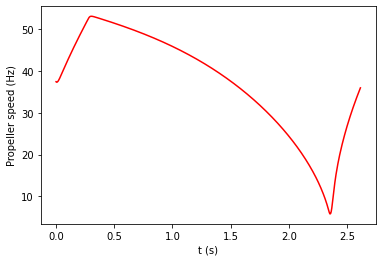

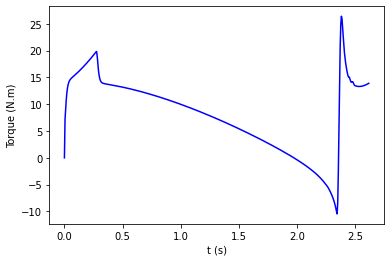

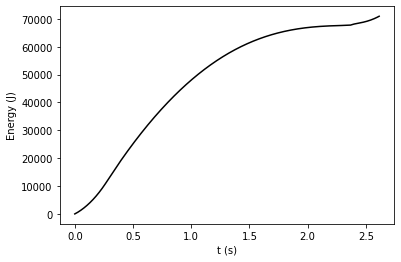

interactive(children=(Dropdown(description='Type', options=('Battery & ESC', 'Constraints', 'Frame', 'Motor', …

In [22]:
# Initial characteristics before optimization 
print("-----------------------------------------------")
print("Initial characteristics before optimization :")
sizing_code(parameters,'Fig')
sizing_code(parameters,'Prt')
print("-----------------------------------------------")

Then we can solve the problem and print of the optimized solution:

In [23]:
# Optimization with SLSQP algorithm
contrainte = lambda x: sizing_code(x, 'Const')
objectif = lambda x: sizing_code(x, 'Obj')
objectifP = lambda x: sizing_code(x, 'ObjP')

SLSQP = True # Optimization algorithm choice

# Optimization bounds
# beta,  k_os, k_ND, k_mot, k_speed_mot, k_mb, k_vb, k_D, a_to,  alpha, k_time
bounds = [(0.3,0.6), (1,10), (1,2), (1,2), (1,2), (0.1,10), (1,2), (0.01,0.99), (0.1,5), (0.05,0.3), (1,2)]

if SLSQP == True:
    # SLSQP omptimisation
    result = scipy.optimize.fmin_slsqp(func=objectif, x0=parameters, 
                                   bounds=bounds,
                                   f_ieqcons=contrainte, iter=100, acc=0.01, iprint = 2, epsilon=.01)
else:
    # Differential evolution omptimisation
    result = scipy.optimize.differential_evolution(func=objectifP,
                                   bounds=bounds,
                                   tol=1e-12)



interactive(children=(Dropdown(description='Type', options=('Battery & ESC', 'Constraints', 'Frame', 'Motor', …

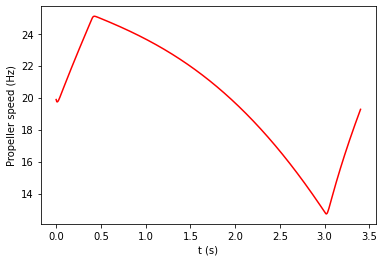

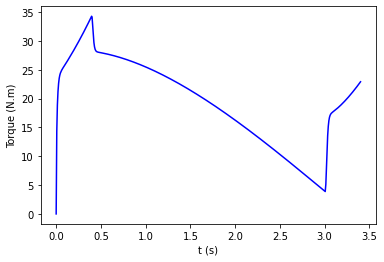

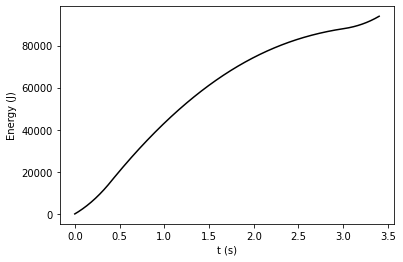

In [24]:
# Final characteristics after optimization 
print("-----------------------------------------------")
print("Final characteristics after optimization :")

if SLSQP == True:
    sizing_code(result,'Obj')
    sizing_code(result, 'Prt')
    sizing_code(result, 'Fig')
else:
    sizing_code(result.x,'Obj')
    sizing_code(result.x, 'Prt')
print("-----------------------------------------------")

In [15]:
result = np.array([0.44745754, 3.49956024, 1.16943738, 1.46598142, 1.1957876 ,
       1.43170901, 1.06933601, 0.01000099, 0.78010614, 0.11499741,
       1.30705342])
parameters=result


In [16]:
df=sizing_code(result, 'Prt')


interactive(children=(Dropdown(description='Type', options=('Battery & ESC', 'Constraints', 'Frame', 'Motor', …

Pour une masse utile de 25 kg
Quadrirotor, 1 moteur par bras

150 montées de 10 m
tps de hover variant



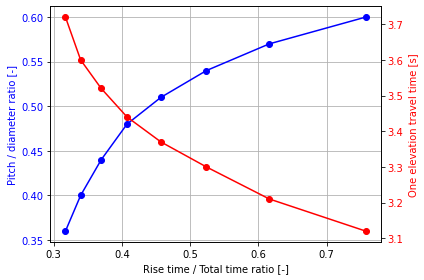

In [17]:
Hover_time=np.array([1*150,2*150,3*150,4*150, 5*150, 6*150,7*150,8*150])
Rise_time=np.array([3.12,3.21,3.3,3.37 ,3.44 ,3.52,3.60,3.72])
Total_Rise_time=150*Rise_time
Alpha=np.array([0.09,0.09,0.1,0.1,0.11,0.11,0.12,.13])
Beta=np.array([0.6,.57,.54,.51,0.48,.44,.4,0.36])
Total_time=Hover_time + Total_Rise_time

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
plt.grid(axis='both')

color = 'tab:red'
ax1.set_xlabel('Rise time / Total time ratio [-]')
ax1.set_ylabel('Pitch / diameter ratio [-]', color='blue')
ax1.plot(Total_Rise_time / Total_time,Beta, 'o-b')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('One elevation travel time [s]', color='red')  # we already handled the x-label with ax1
ax2.plot(Total_Rise_time / Total_time,Rise_time, 'o-r')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('ElevationResults.png', format= 'png')
plt.show()

